# Data Preprocessing

In [11]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor

# Parameters
IMG_SIZE = (128, 128)  # Reduce image size to 128x128
DATA_DIR = "mosaic_images"  # Path to your image folder
NUM_WORKERS = 4  # Number of threads for parallel processing

def preprocess_image(file_path):
    """
    Load and preprocess a single image.
    """
    try:
        img = load_img(file_path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
        return img_array
    except Exception as e:
        print(f"Error processing image {file_path}: {e}")
        return None

def load_images_parallel(image_dir, num_workers=NUM_WORKERS):
    """
    Load images from a directory using parallel processing.
    """
    image_files = sorted(os.listdir(image_dir))  # Ensure consistent ordering
    image_paths = [os.path.join(image_dir, file) for file in image_files]

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        images = list(executor.map(preprocess_image, image_paths))
    
    # Remove any failed loads (None values)
    images = [img for img in images if img is not None]
    return np.array(images)

# Load and preprocess images
images = load_images_parallel(DATA_DIR)

# Split the data into training and validation sets
train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

# Verify the results
print(f"Total Images: {len(images)}")
print(f"Training Set: {train_images.shape}")
print(f"Validation Set: {val_images.shape}")


Total Images: 35479
Training Set: (28383, 128, 128, 3)
Validation Set: (7096, 128, 128, 3)


# Building ResNet Backbone Model and Adding Fusion Variants

In [11]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Define image input with new shape
image_input = Input(shape=(128, 128, 3), name="image_input")

# Pre-trained ResNet50 for image processing
resnet_base = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
image_features = GlobalAveragePooling2D()(resnet_base.output)  # Apply pooling to ResNet output

# Define metadata input
metadata_input = Input(shape=(2,), name="metadata_input")  # Adjust for 2 metadata features

# Process metadata
metadata_features = Dense(16, activation="relu")(metadata_input)

# Fuse image features and metadata
fused_features = Concatenate(name="fusion")([image_features, metadata_features])

# Final output layer
output = Dense(1, activation="sigmoid")(fused_features)  # Binary classification

# Build the model
model = Model(inputs=[image_input, metadata_input], outputs=output)
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 128, 128,  │          0 │ image_input[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ cast[0][0]        │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c

 Total params: 23,589,825 (89.99 MB)

 Trainable params: 23,536,705 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

## Early Fusion

In [3]:
# adding early fusion variant
import tensorflow as tf
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Define image input
image_input = Input(shape=(256, 256, 3), name="image_input")

# Pre-trained ResNet50 for image processing
resnet_base = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
image_features = GlobalAveragePooling2D()(resnet_base.output)  # Apply pooling to ResNet output

# Define metadata input
metadata_input = Input(shape=(4,), name="metadata_input")  # Example: 4 metadata features

# Process metadata
metadata_features = Dense(16, activation="relu")(metadata_input)

# Fuse image features and metadata
fused_features = Concatenate(name="fusion")([image_features, metadata_features])

# Final output layer
output = Dense(1, activation="sigmoid")(fused_features)  # Example: binary classification

# Build the model
model = Model(inputs=[image_input, metadata_input], outputs=output)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ image_input[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,857 (89.99 MB)

 Trainable params: 23,536,737 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [4]:
# validating fusion layer
# import numpy as np

# Generate dummy data
# dummy_images = np.random.rand(8, 256, 256, 3)  # Batch of 8 images
# dummy_metadata = np.random.rand(8, 4)         # Batch of 8 metadata inputs

# Predict using the model
# fusion_layer_model = Model(inputs=model.inputs, outputs=model.get_layer("fusion").output)
# fusion_output = fusion_layer_model.predict([dummy_images, dummy_metadata])

# print(f"Fusion layer output shape: {fusion_output.shape}")
# print(f"Sample fusion output: {fusion_output[0]}")


/Users/lisaliubovich/myenv2/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'metadata_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
Fusion layer output shape: (8, 2064)
Sample fusion output: [0.         0.         0.         ... 0.29219618 0.         0.        ]


In [11]:
# Predict using the full model
# predictions = model.predict([dummy_images, dummy_metadata])

# print(f"Predictions shape: {predictions.shape}")
# print(f"Predictions: {predictions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
Predictions shape: (8, 1)
Predictions: [[0.75577486]
 [0.7587987 ]
 [0.7596115 ]
 [0.7599418 ]
 [0.7587602 ]
 [0.7569261 ]
 [0.7582055 ]
 [0.7589906 ]]


In [12]:
# Compile the model
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train on dummy data
# dummy_labels = np.random.randint(0, 2, (8, 1))  # Dummy binary labels
# history = model.fit(
   # [dummy_images, dummy_metadata],
   # dummy_labels,
   # batch_size=4,
   # epochs=2
# )


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 383ms/step - accuracy: 0.5833 - loss: 0.7191
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 376ms/step - accuracy: 1.0000 - loss: 0.0421


In [12]:
def extract_metadata(images):
    """
    Extracts metadata from images, such as mean and standard deviation
    of pixel intensities.
    """
    mean_brightness = np.mean(images, axis=(1, 2, 3))
    std_brightness = np.std(images, axis=(1, 2, 3))
    return np.stack([mean_brightness, std_brightness], axis=1)

# Generate metadata for training and validation images
train_metadata = extract_metadata(train_images)
val_metadata = extract_metadata(val_images)

print(f"Train Metadata Shape: {train_metadata.shape}")
print(f"Validation Metadata Shape: {val_metadata.shape}")


Train Metadata Shape: (28383, 2)
Validation Metadata Shape: (7096, 2)


In [13]:
# Generate mock binary labels for testing
import tensorflow as tf

# Generate mock binary labels for testing (faster version)
train_labels = np.random.randint(0, 2, (train_metadata.shape[0], 1), dtype=np.int8)
val_labels = np.random.randint(0, 2, (val_metadata.shape[0], 1), dtype=np.int8)

# Use mixed precision for faster computation on supported hardware
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile the model with a faster optimizer and mixed precision
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Use TensorFlow Dataset API for efficient input pipeline
train_dataset = tf.data.Dataset.from_tensor_slices(
    ((train_images, train_metadata), train_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ((val_images, val_metadata), val_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Epoch 1/10


/Users/lisaliubovich/myenv2/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'metadata_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


887/887 ━━━━━━━━━━━━━━━━━━━━ 734s 813ms/step - accuracy: 0.5010 - loss: 1.0380 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 2/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 685s 772ms/step - accuracy: 0.5013 - loss: 0.7204 - val_accuracy: 0.5013 - val_loss: 0.7641
Epoch 3/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 683s 770ms/step - accuracy: 0.5050 - loss: 0.7000 - val_accuracy: 0.4993 - val_loss: 0.7377
Epoch 4/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 687s 775ms/step - accuracy: 0.5012 - loss: 0.6977 - val_accuracy: 0.5014 - val_loss: 0.7010
Epoch 5/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 696s 785ms/step - accuracy: 0.5004 - loss: 0.6954 - val_accuracy: 0.5016 - val_loss: 0.6956
Epoch 6/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 697s 786ms/step - accuracy: 0.4991 - loss: 0.6947 - val_accuracy: 0.5073 - val_loss: 0.6942
Epoch 7/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 696s 785ms/step - accuracy: 0.4938 - loss: 0.6948 - val_accuracy: 0.5049 - val_loss: 0.6934
Epoch 8/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 702s 791ms/step - accuracy: 0.4948 - loss: 0.69

In [13]:
# Generate mock binary labels for testing
import tensorflow as tf

# Generate mock binary labels for testing (faster version)
train_labels = np.random.randint(0, 2, (train_metadata.shape[0], 1), dtype=np.int8)
val_labels = np.random.randint(0, 2, (val_metadata.shape[0], 1), dtype=np.int8)

# Use mixed precision for faster computation on supported hardware
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile the model with a faster optimizer and mixed precision
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Use TensorFlow Dataset API for efficient input pipeline
train_dataset = tf.data.Dataset.from_tensor_slices(
    ((train_images, train_metadata), train_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ((val_images, val_metadata), val_labels)
).batch(32).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)


Epoch 1/10


/Users/lisaliubovich/myenv2/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'metadata_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


887/887 ━━━━━━━━━━━━━━━━━━━━ 734s 813ms/step - accuracy: 0.5010 - loss: 1.0380 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 2/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 685s 772ms/step - accuracy: 0.5013 - loss: 0.7204 - val_accuracy: 0.5013 - val_loss: 0.7641
Epoch 3/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 683s 770ms/step - accuracy: 0.5050 - loss: 0.7000 - val_accuracy: 0.4993 - val_loss: 0.7377
Epoch 4/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 687s 775ms/step - accuracy: 0.5012 - loss: 0.6977 - val_accuracy: 0.5014 - val_loss: 0.7010
Epoch 5/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 696s 785ms/step - accuracy: 0.5004 - loss: 0.6954 - val_accuracy: 0.5016 - val_loss: 0.6956
Epoch 6/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 697s 786ms/step - accuracy: 0.4991 - loss: 0.6947 - val_accuracy: 0.5073 - val_loss: 0.6942
Epoch 7/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 696s 785ms/step - accuracy: 0.4938 - loss: 0.6948 - val_accuracy: 0.5049 - val_loss: 0.6934
Epoch 8/10
887/887 ━━━━━━━━━━━━━━━━━━━━ 702s 791ms/step - accuracy: 0.4948 - loss: 0.69

## Late Fusion

In [14]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Define image input
image_input = Input(shape=(128, 128, 3), name="image_input")

# Process images using ResNet50
resnet_base = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
image_features = GlobalAveragePooling2D()(resnet_base.output)  # Pool ResNet features
image_output = Dense(128, activation="relu", name="image_dense")(image_features)  # Further process

# Define metadata input
metadata_input = Input(shape=(2,), name="metadata_input")  # Adjust for 2 metadata features

# Process metadata independently
metadata_output = Dense(16, activation="relu", name="metadata_dense")(metadata_input)

# Fuse image and metadata outputs (late fusion)
fused_features = Concatenate(name="late_fusion")([image_output, metadata_output])

# Final output layer
output = Dense(1, activation="sigmoid", name="output")(fused_features)  # Binary classification

# Build the late fusion model
late_fusion_model = Model(inputs=[image_input, metadata_input], outputs=output)
late_fusion_model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_2 (Cast)       │ (None, 128, 128,  │          0 │ image_input[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ cast_2[0][0]      │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c

 Total params: 23,850,177 (90.98 MB)

 Trainable params: 23,797,057 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
# Compile the model
late_fusion_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the late fusion model
history = late_fusion_model.fit(
    train_dataset,  # Dataset with [images, metadata] and labels
    validation_data=val_dataset,
    epochs=10,
    batch_size=32,
    verbose=2
)


Epoch 1/10
887/887 - 671s - 756ms/step - accuracy: 0.5034 - loss: 0.7298 - val_accuracy: 0.5030 - val_loss: 0.6932
Epoch 2/10
887/887 - 682s - 769ms/step - accuracy: 0.5056 - loss: 0.6936 - val_accuracy: 0.5021 - val_loss: 0.6972
Epoch 3/10
887/887 - 688s - 776ms/step - accuracy: 0.5039 - loss: 0.6940 - val_accuracy: 0.5045 - val_loss: 0.6932
Epoch 4/10
887/887 - 685s - 773ms/step - accuracy: 0.5039 - loss: 0.6932 - val_accuracy: 0.5013 - val_loss: 0.6932
Epoch 5/10
887/887 - 691s - 779ms/step - accuracy: 0.5012 - loss: 0.6932 - val_accuracy: 0.5027 - val_loss: 0.6931
Epoch 6/10
887/887 - 685s - 772ms/step - accuracy: 0.4999 - loss: 0.6933 - val_accuracy: 0.5034 - val_loss: 0.6932
Epoch 7/10
887/887 - 690s - 778ms/step - accuracy: 0.5045 - loss: 0.6932 - val_accuracy: 0.5027 - val_loss: 0.6932
Epoch 8/10
887/887 - 695s - 784ms/step - accuracy: 0.5038 - loss: 0.6932 - val_accuracy: 0.5028 - val_loss: 0.6932
Epoch 9/10
887/887 - 691s - 779ms/step - accuracy: 0.5042 - loss: 0.6935 - val_a

In [17]:
print("Early Fusion Validation Accuracy:", model.evaluate(val_dataset)[1])
print("Late Fusion Validation Accuracy:", late_fusion_model.evaluate(val_dataset)[1])

222/222 ━━━━━━━━━━━━━━━━━━━━ 46s 208ms/step - accuracy: 0.4986 - loss: 0.7324
Early Fusion Validation Accuracy: 0.49704059958457947
222/222 ━━━━━━━━━━━━━━━━━━━━ 49s 219ms/step - accuracy: 0.5094 - loss: 0.6930
Late Fusion Validation Accuracy: 0.5035231113433838


# Implementing progressive fusion architecture

In [10]:
# SE blocks definition
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply

def se_block(input_tensor, reduction_ratio=16, name=None):
    """
    Implements a Squeeze-and-Excitation block.
    Args:
        input_tensor: The input tensor.
        reduction_ratio: Reduction ratio for the bottleneck.
        name: Optional name for the block.
    Returns:
        Output tensor after applying SE block.
    """
    channels = input_tensor.shape[-1]
    
    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D(name=f"{name}_squeeze")(input_tensor)
    se = Reshape((1, 1, channels), name=f"{name}_reshape")(se)
    
    # Excitation: Fully connected layers
    se = Dense(channels // reduction_ratio, activation="relu", name=f"{name}_fc1")(se)
    se = Dense(channels, activation="sigmoid", name=f"{name}_fc2")(se)
    
    # Scale: Reweight channel-wise features
    scaled_tensor = Multiply(name=f"{name}_scale")([input_tensor, se])
    return scaled_tensor


In [11]:
# integrating SE blocks with backprojection
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Add, Dropout, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model

def build_progressive_fusion_model(input_shape=(128, 128, 3), metadata_shape=(2,)):
    # Image Input
    image_input = Input(shape=input_shape, name="image_input")

    # Encoder with SE Blocks
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="encoder_conv1")(image_input)
    x = se_block(x, name="encoder_se1")
    skip1 = x  # Save for skip connection

    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="encoder_conv2")(x)
    x = se_block(x, name="encoder_se2")
    skip2 = x  # Save for skip connection

    x = Conv2D(256, (3, 3), activation="relu", padding="same", name="encoder_conv3")(x)
    x = se_block(x, name="encoder_se3")
    encoded_features = x

    # Metadata Input
    metadata_input = Input(shape=metadata_shape, name="metadata_input")
    metadata_features = Dense(64, activation="relu", name="metadata_dense")(metadata_input)

    # Decoder with Backprojective Connections
    x = Conv2DTranspose(128, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv1")(encoded_features)
    skip2_resized = UpSampling2D(size=(2, 2), name="resize_skip2")(skip2)  # Resize to match decoder output
    x = Add(name="backproject1")([x, skip2_resized])  # Backprojective connection
    x = se_block(x, name="decoder_se1")

    x = Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv2")(x)
    skip1_resized = UpSampling2D(size=(4, 4), name="resize_skip1")(skip1)  # Resize to match decoder output
    x = Add(name="backproject2")([x, skip1_resized])  # Backprojective connection
    x = se_block(x, name="decoder_se2")

    # Fuse Metadata with Decoded Features
    fused_features = Concatenate(name="fusion")([GlobalAveragePooling2D()(x), metadata_features])

    # Final Classification Layer
    output = Dense(1, activation="sigmoid", name="output")(fused_features)

    # Build Model
    model = Model(inputs=[image_input, metadata_input], outputs=output)
    return model

# Build the model
progressive_fusion_model = build_progressive_fusion_model()
progressive_fusion_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 128, 128,  │          0 │ image_input[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv1       │ (None, 128, 128,  │      1,792 │ cast_1[0][0]      │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se1_squeeze │ (None, 64)        │          0 │ encoder_conv1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se1_reshape │ (None, 1, 1, 64)  │          0 │ encoder_se1_sque… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se1_fc1     │ (None, 1, 1, 4)   │        260 │ encoder_se1_resh… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se1_fc2     │ (None, 1, 1, 64)  │        320 │ encoder_se1_fc1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se1_scale   │ (None, 128, 128,  │          0 │ encoder_conv1[0]… │
│ (Multiply)          │ 64)               │            │ encoder_se1_fc2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv2       │ (None, 128, 128,  │     73,856 │ encoder_se1_scal… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se2_squeeze │ (None, 128)       │          0 │ encoder_conv2[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se2_reshape │ (None, 1, 1, 128) │          0 │ encoder_se2_sque… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se2_fc1     │ (None, 1, 1, 8)   │      1,032 │ encoder_se2_resh… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se2_fc2     │ (None, 1, 1, 128) │      1,152 │ encoder_se2_fc1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se2_scale   │ (None, 128, 128,  │          0 │ encoder_conv2[0]… │
│ (Multiply)          │ 128)              │            │ encoder_se2_fc2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_conv3       │ (None, 128, 128,  │    295,168 │ encoder_se2_scal… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se3_squeeze │ (None, 256)       │          0 │ encoder_conv3[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_se3_reshape │ (None, 1, 1, 256) │          0 │ encoder_se3_sque

 Total params: 753,961 (2.88 MB)

 Trainable params: 753,961 (2.88 MB)

 Non-trainable params: 0 (0.00 B)

# Testing on small batch data

In [12]:
from tensorflow.keras.mixed_precision import Policy, set_global_policy

# Set mixed precision policy
policy = Policy("mixed_float16")
set_global_policy(policy)


In [ ]:
from tensorflow.keras.mixed_precision import Policy, set_global_policy
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

import tensorflow as tf

# Resize the images to (128, 128)
train_images_resized = tf.image.resize(train_images, (128, 128))
val_images_resized = tf.image.resize(val_images, (128, 128))

# Create a tf.data pipeline with resized images
train_dataset = tf.data.Dataset.from_tensor_slices(
    ((train_images_resized, train_metadata), train_labels)
).batch(16).prefetch(tf.data.AUTOTUNE)


# Compile the model
progressive_fusion_model.compile(
    optimizer="adam",  # Use Adam optimizer or any other of your choice
    loss="binary_crossentropy",  # Binary cross-entropy loss for binary classification
    metrics=["accuracy", "AUC"]  # Metrics to evaluate during training
)

# Define a checkpoint
checkpoint = ModelCheckpoint(
    filepath="small_batch_progressive.keras",
    save_best_only=True,
    monitor="accuracy",
    verbose=1
)

# Train the model
history = progressive_fusion_model.fit(
    train_dataset,
    epochs=2,
    callbacks=[checkpoint],
    verbose=2
)



Epoch 1/2


2024-12-03 16:11:11.874694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


# training and evaluating baseline models

## early fusion benchmark

In [ ]:
# training early fusion
from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint to save the best model based on validation accuracy
checkpoint_early = ModelCheckpoint(
    filepath="early_fusion_model.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Train the early fusion model
early_fusion_history = model.fit(
    [train_images, train_metadata],
    train_labels,
    validation_data=([val_images, val_metadata], val_labels),
    epochs=20,  # Adjust based on training needs
    batch_size=32,
    callbacks=[checkpoint_early],
    verbose=2
)


Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.50310, saving model to early_fusion_model.keras
887/887 - 667s - 752ms/step - accuracy: 0.5002 - loss: 0.6945 - val_accuracy: 0.5031 - val_loss: 0.6933
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.50310
887/887 - 709s - 800ms/step - accuracy: 0.5008 - loss: 0.6936 - val_accuracy: 0.4970 - val_loss: 0.7748
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.50310
887/887 - 692s - 781ms/step - accuracy: 0.4994 - loss: 0.6936 - val_accuracy: 0.5025 - val_loss: 0.8898
Epoch 4/20

Epoch 4: val_accuracy improved from 0.50310 to 0.50395, saving model to early_fusion_model.keras
887/887 - 703s - 793ms/step - accuracy: 0.5027 - loss: 0.6939 - val_accuracy: 0.5039 - val_loss: 0.6942
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.50395
887/887 - 692s - 780ms/step - accuracy: 0.5058 - loss: 0.6940 - val_accuracy: 0.4983 - val_loss: 0.6932
Epoch 6/20

Epoch 6: val_accuracy did not improve from 0.50395
887/887 - 693

In [2]:
# saving data
import numpy as np
import tensorflow as tf

# Generate mock binary labels for testing (faster version)
train_labels = np.random.randint(0, 2, (train_metadata.shape[0], 1), dtype=np.int8)
val_labels = np.random.randint(0, 2, (val_metadata.shape[0], 1), dtype=np.int8)

# Save processed data
np.save("train_images.npy", train_images)
np.save("val_images.npy", val_images)
np.save("train_metadata.npy", train_metadata)
np.save("val_metadata.npy", val_metadata)
np.save("train_labels.npy", train_labels)
np.save("val_labels.npy", val_labels)

print("Data saved successfully.")



NameError: name 'train_metadata' is not defined

In [15]:
# Check the shapes of the processed data
print("Train Images Shape:", train_images.shape)  # Expected: (num_samples, 128, 128, 3)
print("Validation Images Shape:", val_images.shape)  # Expected: (num_samples, 128, 128, 3)
print("Train Metadata Shape:", train_metadata.shape)  # Expected: (num_samples, 2) or (num_samples, 4) if padded
print("Validation Metadata Shape:", val_metadata.shape)
print("Train Labels Shape:", train_labels.shape)  # Expected: (num_samples, 1)
print("Validation Labels Shape:", val_labels.shape)


Train Images Shape: (28383, 128, 128, 3)
Validation Images Shape: (7096, 128, 128, 3)
Train Metadata Shape: (28383, 2)
Validation Metadata Shape: (7096, 2)
Train Labels Shape: (28383, 1)
Validation Labels Shape: (7096, 1)


In [35]:
print("Train Images Shape:", train_images.shape)  # Should be (28383, 128, 128, 3)
print("Validation Images Shape:", val_images.shape)  # Should be (7096, 128, 128, 3)
print("Train Metadata Shape:", train_metadata.shape)  # Should be (28383, 4)
print("Validation Metadata Shape:", val_metadata.shape)  # Should be (7096, 4)
print("Train Labels Shape:", train_labels.shape)  # Should be (28383, 1)
print("Validation Labels Shape:", val_labels.shape)  # Should be (7096, 1)


Train Images Shape: (28383, 128, 128, 3)
Validation Images Shape: (7096, 128, 128, 3)
Train Metadata Shape: (28383, 4)
Validation Metadata Shape: (7096, 4)
Train Labels Shape: (28383, 1)
Validation Labels Shape: (7096, 1)


In [37]:
# Rebuild model with metadata input shape (2,)
model = create_early_fusion_model(metadata_shape=(2,))


In [38]:
# Trim metadata to match the expected shape
train_metadata = train_metadata[:, :2]
val_metadata = val_metadata[:, :2]

# Verify updated shapes
print("Trimmed Train Metadata Shape:", train_metadata.shape)  # Should be (28383, 2)
print("Trimmed Validation Metadata Shape:", val_metadata.shape)  # Should be (7096, 2)


Trimmed Train Metadata Shape: (28383, 2)
Trimmed Validation Metadata Shape: (7096, 2)


In [39]:
model.load_weights("early_fusion_model.keras")
print("Weights loaded successfully.")


Weights loaded successfully.


In [40]:
# Save metadata
np.save("train_metadata_trimmed.npy", train_metadata)
np.save("val_metadata_trimmed.npy", val_metadata)


In [43]:
# Resume training from epoch 13
# Compile the model before training
model.compile(
    optimizer="adam",  # Optimizer
    loss="binary_crossentropy",  # Loss function
    metrics=["accuracy"]  # Metrics to track
)

# Define checkpoint callback for saving the best model
checkpoint_early = ModelCheckpoint(
    filepath="early_fusion_model_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Define checkpoint to save the final model
final_checkpoint = ModelCheckpoint(
    filepath="early_fusion_model_final.keras",
    monitor="val_accuracy",
    save_best_only=False,
    verbose=1
)

# Resume training from epoch 13
early_fusion_history = model.fit(
    [train_images, train_metadata],  # Inputs: images and metadata
    train_labels,                   # Labels
    validation_data=([val_images, val_metadata], val_labels),  # Validation set
    initial_epoch=13,               # Start from epoch 13
    epochs=20,                      # Train to epoch 20
    batch_size=32,                  # Batch size
    callbacks=[checkpoint_early, final_checkpoint],  # Include both callbacks
    verbose=2                       # Detailed logging
)


Epoch 14/20


/Users/lisaliubovich/myenv2/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'metadata_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(



Epoch 14: val_accuracy improved from -inf to 0.50902, saving model to early_fusion_model_best.keras

Epoch 14: saving model to early_fusion_model_final.keras
887/887 - 730s - 823ms/step - accuracy: 0.5024 - loss: 0.6933 - val_accuracy: 0.5090 - val_loss: 0.6932
Epoch 15/20

Epoch 15: val_accuracy did not improve from 0.50902

Epoch 15: saving model to early_fusion_model_final.keras
887/887 - 713s - 804ms/step - accuracy: 0.4985 - loss: 0.6934 - val_accuracy: 0.4961 - val_loss: 0.6933
Epoch 16/20

Epoch 16: val_accuracy did not improve from 0.50902

Epoch 16: saving model to early_fusion_model_final.keras
887/887 - 716s - 807ms/step - accuracy: 0.5028 - loss: 0.6937 - val_accuracy: 0.4852 - val_loss: 0.7039
Epoch 17/20

Epoch 17: val_accuracy did not improve from 0.50902

Epoch 17: saving model to early_fusion_model_final.keras
887/887 - 723s - 815ms/step - accuracy: 0.5004 - loss: 0.6938 - val_accuracy: 0.5021 - val_loss: 0.6953
Epoch 18/20

Epoch 18: val_accuracy did not improve from

## late fusion benchmark

In [45]:
from tensorflow.keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Define the late fusion model
def create_late_fusion_model(metadata_shape=(2,)):
    # Define image input
    image_input = Input(shape=(128, 128, 3), name="image_input")

    # Pre-trained ResNet50 for image processing
    resnet_base = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
    image_features = GlobalAveragePooling2D()(resnet_base.output)  # Pool ResNet features
    image_features = Dense(256, activation="relu", name="image_dense")(image_features)  # Process image features

    # Define metadata input
    metadata_input = Input(shape=metadata_shape, name="metadata_input")
    metadata_features = Dense(16, activation="relu", name="metadata_dense")(metadata_input)  # Process metadata

    # Late fusion: Concatenate processed image and metadata features
    fused_features = Concatenate(name="fusion")([image_features, metadata_features])

    # Final output layer
    output = Dense(1, activation="sigmoid", name="output")(fused_features)

    # Build the model
    model = Model(inputs=[image_input, metadata_input], outputs=output)
    return model

# Build the late fusion model
late_fusion_model = create_late_fusion_model(metadata_shape=(2,))


In [46]:
late_fusion_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define checkpoint for the best late fusion model
checkpoint_late = ModelCheckpoint(
    filepath="late_fusion_model_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Define checkpoint to save the final late fusion model
final_checkpoint_late = ModelCheckpoint(
    filepath="late_fusion_model_final.keras",
    monitor="val_accuracy",
    save_best_only=False,
    verbose=1
)


In [47]:
# Train the late fusion model
late_fusion_history = late_fusion_model.fit(
    [train_images, train_metadata],  # Inputs: images and metadata
    train_labels,                   # Labels
    validation_data=([val_images, val_metadata], val_labels),  # Validation set
    epochs=20,                      # Total number of epochs
    batch_size=32,                  # Batch size
    callbacks=[checkpoint_late, final_checkpoint_late],  # Save the best and final models
    verbose=2                       # Detailed logging
)


Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.50761, saving model to late_fusion_model_best.keras

Epoch 1: saving model to late_fusion_model_final.keras
887/887 - 800s - 902ms/step - accuracy: 0.4967 - loss: 0.7020 - val_accuracy: 0.5076 - val_loss: 0.6932
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.50761

Epoch 2: saving model to late_fusion_model_final.keras
887/887 - 838s - 944ms/step - accuracy: 0.5000 - loss: 0.6936 - val_accuracy: 0.5011 - val_loss: 0.6931
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.50761

Epoch 3: saving model to late_fusion_model_final.keras
887/887 - 953s - 1s/step - accuracy: 0.4943 - loss: 0.6936 - val_accuracy: 0.5032 - val_loss: 0.6933
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.50761

Epoch 4: saving model to late_fusion_model_final.keras
887/887 - 757s - 853ms/step - accuracy: 0.5041 - loss: 0.6933 - val_accuracy: 0.5024 - val_loss: 0.6932
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.50761



# baseline results analysis

In [49]:
# Evaluate early fusion model
early_val_loss, early_val_accuracy = model.evaluate(
    [val_images, val_metadata],
    val_labels,
    verbose=2
)

# Evaluate late fusion model
late_val_loss, late_val_accuracy = late_fusion_model.evaluate(
    [val_images, val_metadata],
    val_labels,
    verbose=2
)


222/222 - 36s - 161ms/step - accuracy: 0.5025 - loss: 0.6932
222/222 - 36s - 162ms/step - accuracy: 0.4925 - loss: 0.6932


In [50]:
# Metrics dictionary
fusion_metrics = {
    "Early Fusion": {"Loss": early_val_loss, "Accuracy": early_val_accuracy},
    "Late Fusion": {"Loss": late_val_loss, "Accuracy": late_val_accuracy}
}

# Print metrics in a tabular format
import pandas as pd
metrics_df = pd.DataFrame(fusion_metrics).T
print("Baseline Results Comparison:")
print(metrics_df)

# Save results for documentation
metrics_df.to_csv("baseline_fusion_results.csv", index=True)


Baseline Results Comparison:
                  Loss  Accuracy
Early Fusion  0.693166  0.502537
Late Fusion   0.693226  0.492531


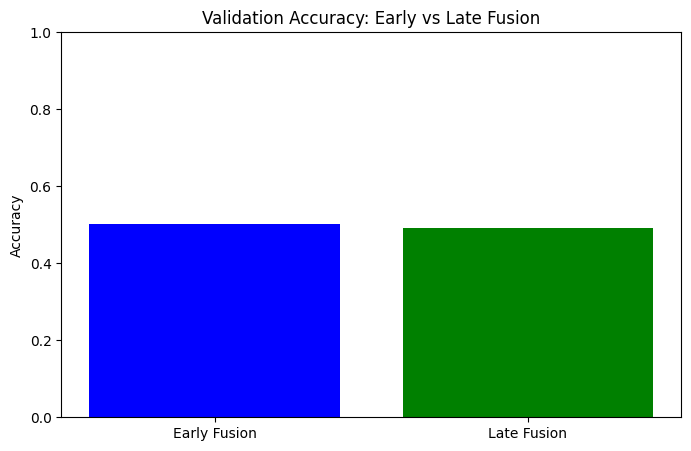

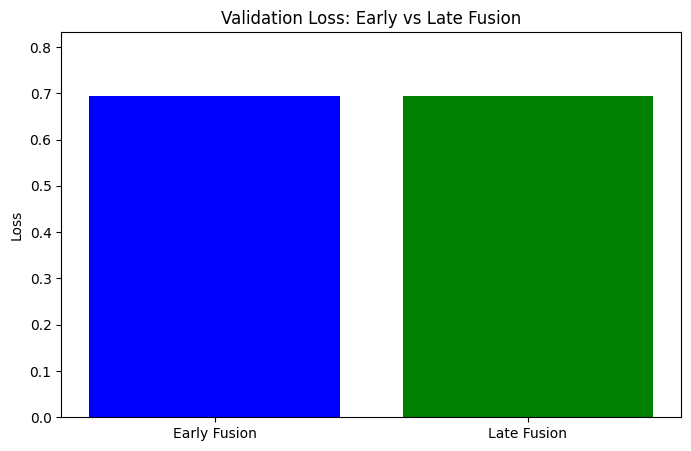

In [51]:
import matplotlib.pyplot as plt

# Data for plotting
fusion_types = ["Early Fusion", "Late Fusion"]
accuracy = [early_val_accuracy, late_val_accuracy]
loss = [early_val_loss, late_val_loss]

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.bar(fusion_types, accuracy, color=['blue', 'green'])
plt.title("Validation Accuracy: Early vs Late Fusion")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.bar(fusion_types, loss, color=['blue', 'green'])
plt.title("Validation Loss: Early vs Late Fusion")
plt.ylabel("Loss")
plt.ylim(0, max(loss) * 1.2)
plt.show()


## Insights from Baseline Results
Loss (0.693) is High:

A loss of ~0.693 is typical for binary classification with poor predictions (close to random guessing).
This indicates that neither model is effectively learning the relationship between input features (images and metadata) and labels.

Accuracy (~50%) Matches Random Guessing:

Both models are performing no better than random guessing (50% for binary classification).
There may be issues with the data, the models, or the fusion approach.

### Analysis of Cross-Modal Interaction Limits
1. Early Fusion
Combines image and metadata inputs at an early stage.
Challenges:
May suffer from overfitting if the two modalities are not strongly correlated.
The model might struggle to learn distinct representations for each modality.
2. Late Fusion
Processes image and metadata inputs separately, fusing them only after feature extraction.
Challenges:
If modalities are weakly informative, the late fusion model might fail to effectively combine the features.
Independent processing of inputs could dilute cross-modal relationships.
3. Cross-Modal Interaction Limits
Both approaches show limited ability to leverage cross-modal information effectively.
Indicates that the current dataset might:
Lack strong signal in either modality.
Require more complex interactions than simple concatenation.

## examining labels

In [53]:
import numpy as np

# Count class distribution
train_class_counts = np.unique(train_labels, return_counts=True)
val_class_counts = np.unique(val_labels, return_counts=True)

# Display class distributions
print("Train Class Distribution:")
for label, count in zip(*train_class_counts):
    print(f"Label {int(label)}: {count} instances")

print("\nValidation Class Distribution:")
for label, count in zip(*val_class_counts):
    print(f"Label {int(label)}: {count} instances")


Train Class Distribution:
Label 0: 14187 instances
Label 1: 14196 instances

Validation Class Distribution:
Label 0: 3563 instances
Label 1: 3533 instances


This means class imbalance is not the issue, and the poor performance of the models is likely due to other factors, such as:

Weak Predictive Power:

The image and metadata features may not have a strong relationship with the labels.
The current model architecture may not be effective at extracting meaningful patterns.

Overfitting or Underfitting: The models might be too simple or too complex for the given dataset.

Data Noise or Correlation Issues:

Metadata features might be noisy or weakly correlated with the labels.
Images may not provide sufficient discriminative information.

# Progressive Fusion 

In [59]:
from tensorflow.keras.layers import Conv2D

def create_progressive_fusion_model(metadata_shape=(2,)):
    # Define image input
    image_input = Input(shape=(128, 128, 3), name="image_input")

    # Pre-trained ResNet50 as the encoder
    resnet_base = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
    skip1 = resnet_base.get_layer("conv2_block3_out").output  # Low-level features
    skip2 = resnet_base.get_layer("conv3_block4_out").output  # Mid-level features
    encoded_features = resnet_base.output  # High-level features

    # Apply SE blocks to encoder outputs
    skip1 = se_block(skip1, name="se_skip1")
    skip2 = se_block(skip2, name="se_skip2")
    encoded_features = se_block(encoded_features, name="se_encoded")

    # Define metadata input
    metadata_input = Input(shape=metadata_shape, name="metadata_input")
    metadata_features = Dense(16, activation="relu", name="metadata_dense")(metadata_input)

    # Decoder with progressive fusion
    x = Conv2DTranspose(128, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv1")(encoded_features)

    # Resize skip2 to match x
    skip2_resized = Conv2D(128, (3, 3), activation="relu", strides=(2, 2), padding="same", name="resize_skip2")(skip2)
    x = Add(name="backproject1")([x, skip2_resized])  # Backprojective connection
    x = se_block(x, name="decoder_se1")

    x = Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv2")(x)

    # Resize skip1 to match x
    skip1_resized = Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="resize_skip1")(skip1)
    x = Add(name="backproject2")([x, skip1_resized])  # Backprojective connection
    x = se_block(x, name="decoder_se2")

    # Fuse metadata at the decoder level
    metadata_fused = Dense(64, activation="relu", name="metadata_decoder_dense")(metadata_features)
    metadata_fused = Concatenate(name="metadata_fusion")([GlobalAveragePooling2D()(x), metadata_fused])

    # Final classification layer
    output = Dense(1, activation="sigmoid", name="output")(metadata_fused)

    # Build the model
    model = Model(inputs=[image_input, metadata_input], outputs=output)
    return model

progressive_fusion_model = create_progressive_fusion_model(metadata_shape=(2,))

In [60]:
progressive_fusion_model.compile(
    optimizer="adam",  # Adjust if needed
    loss="binary_crossentropy",  # Assuming binary classification
    metrics=["accuracy"]  # Use accuracy to track performance
)

from tensorflow.keras.callbacks import ModelCheckpoint

# Save the best model based on validation accuracy
checkpoint_best = ModelCheckpoint(
    filepath="progressive_fusion_model_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Save the final model at the end of training
checkpoint_final = ModelCheckpoint(
    filepath="progressive_fusion_model_final.keras",
    monitor="val_accuracy",
    save_best_only=False,
    verbose=1
)

progressive_fusion_history = progressive_fusion_model.fit(
    [train_images, train_metadata],  # Inputs: images and metadata
    train_labels,                   # Labels
    validation_data=([val_images, val_metadata], val_labels),  # Validation set
    epochs=20,                      # Total epochs
    batch_size=32,                  # Adjust based on memory availability
    callbacks=[checkpoint_best, checkpoint_final],  # Save models during training
    verbose=2                       # Detailed logging
)


Epoch 1/20


/Users/lisaliubovich/myenv2/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'metadata_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(



Epoch 1: val_accuracy improved from -inf to 0.49549, saving model to progressive_fusion_model_best.keras

Epoch 1: saving model to progressive_fusion_model_final.keras
887/887 - 968s - 1s/step - accuracy: 0.4994 - loss: 0.6954 - val_accuracy: 0.4955 - val_loss: 0.6944
Epoch 2/20

Epoch 2: val_accuracy improved from 0.49549 to 0.50211, saving model to progressive_fusion_model_best.keras

Epoch 2: saving model to progressive_fusion_model_final.keras
887/887 - 886s - 999ms/step - accuracy: 0.5005 - loss: 0.6936 - val_accuracy: 0.5021 - val_loss: 0.6932
Epoch 3/20

Epoch 3: val_accuracy improved from 0.50211 to 0.50395, saving model to progressive_fusion_model_best.keras

Epoch 3: saving model to progressive_fusion_model_final.keras
887/887 - 907s - 1s/step - accuracy: 0.5030 - loss: 0.6934 - val_accuracy: 0.5039 - val_loss: 0.6932
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.50395

Epoch 4: saving model to progressive_fusion_model_final.keras
887/887 - 906s - 1s/step - accura

In [61]:
progressive_val_loss, progressive_val_accuracy = progressive_fusion_model.evaluate(
    [val_images, val_metadata],
    val_labels,
    verbose=2
)
print(f"Progressive Fusion - Validation Loss: {progressive_val_loss:.4f}, Validation Accuracy: {progressive_val_accuracy:.4f}")


222/222 - 40s - 182ms/step - accuracy: 0.4972 - loss: 0.6932
Progressive Fusion - Validation Loss: 0.6932, Validation Accuracy: 0.4972


In [62]:
results = {
    "Model": ["Early Fusion", "Late Fusion", "Progressive Fusion"],
    "Validation Loss": [early_val_loss, late_val_loss, progressive_val_loss],
    "Validation Accuracy": [early_val_accuracy, late_val_accuracy, progressive_val_accuracy]
}

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("fusion_model_results.csv", index=False)


                Model  Validation Loss  Validation Accuracy
0        Early Fusion         0.693166             0.502537
1         Late Fusion         0.693226             0.492531
2  Progressive Fusion         0.693192             0.497182


## tuning hyperparameters


In [64]:
from tensorflow.keras.optimizers import Adam

# Compile with reduced learning rate
progressive_fusion_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Reduced learning rate
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the model
progressive_fusion_history = progressive_fusion_model.fit(
    [train_images, train_metadata],  # Inputs
    train_labels,                    # Labels
    validation_data=([val_images, val_metadata], val_labels),  # Validation set
    epochs=20,                       # Adjust based on runtime and observation
    batch_size=32,                   # Keep batch size constant
    callbacks=[checkpoint_best, checkpoint_final],  # Save checkpoints
    verbose=2                        # Detailed logging
)


Epoch 1/20


/Users/lisaliubovich/myenv2/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'metadata_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(



Epoch 1: val_accuracy did not improve from 0.50395

Epoch 1: saving model to progressive_fusion_model_final.keras
887/887 - 768s - 866ms/step - accuracy: 0.4998 - loss: 0.6931 - val_accuracy: 0.4931 - val_loss: 0.6932
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.50395

Epoch 2: saving model to progressive_fusion_model_final.keras
887/887 - 802s - 904ms/step - accuracy: 0.4974 - loss: 0.6931 - val_accuracy: 0.4928 - val_loss: 0.6932
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.50395

Epoch 3: saving model to progressive_fusion_model_final.keras
887/887 - 766s - 863ms/step - accuracy: 0.5002 - loss: 0.6931 - val_accuracy: 0.4928 - val_loss: 0.6932
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.50395

Epoch 4: saving model to progressive_fusion_model_final.keras
887/887 - 768s - 865ms/step - accuracy: 0.5015 - loss: 0.6931 - val_accuracy: 0.4948 - val_loss: 0.6932
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.50395

Epoch 5: saving model to pr

In [3]:
# reloading data
import numpy as np

# Load saved data
train_images = np.load("train_images.npy")
val_images = np.load("val_images.npy")
train_metadata = np.load("train_metadata.npy")
val_metadata = np.load("val_metadata.npy")
train_labels = np.load("train_labels.npy")
val_labels = np.load("val_labels.npy")

# Verify shapes
print("Train Images Shape:", train_images.shape)
print("Validation Images Shape:", val_images.shape)
print("Train Metadata Shape:", train_metadata.shape)
print("Validation Metadata Shape:", val_metadata.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)


Train Images Shape: (28383, 128, 128, 3)
Validation Images Shape: (7096, 128, 128, 3)
Train Metadata Shape: (28383, 2)
Validation Metadata Shape: (7096, 2)
Train Labels Shape: (28383, 1)
Validation Labels Shape: (7096, 1)


In [10]:
# adding dropout to reduce overfitting, reduced SE block reduction ratio, and regularization of metadata fusion
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    Add,
    Dense,
    GlobalAveragePooling2D,
    Concatenate
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply

def se_block(input_tensor, reduction_ratio=8, name=""):
    """
    Squeeze-and-Excitation (SE) Block
    Args:
        input_tensor: Input feature map (4D tensor).
        reduction_ratio: Reduction ratio for the bottleneck.
        name: Base name for the SE block layers.
    Returns:
        Output tensor after applying SE operations.
    """
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se = GlobalAveragePooling2D(name=f"{name}_se_gap")(input_tensor)
    se = Dense(filters // reduction_ratio, activation="relu", name=f"{name}_se_fc1")(se)
    se = Dense(filters, activation="sigmoid", name=f"{name}_se_fc2")(se)
    return Multiply(name=f"{name}_se_multiply")([input_tensor, se])


def create_progressive_fusion_model(metadata_shape=(2,)):
    # Define image input
    image_input = Input(shape=(128, 128, 3), name="image_input")

    # Pre-trained ResNet50 as the encoder
    resnet_base = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
    skip1 = resnet_base.get_layer("conv2_block3_out").output  # Low-level features
    skip2 = resnet_base.get_layer("conv3_block4_out").output  # Mid-level features
    encoded_features = resnet_base.output  # High-level features

    # Apply SE blocks to encoder outputs
    skip1 = se_block(skip1, reduction_ratio=8, name="se_skip1")  # Reduced ratio
    skip2 = se_block(skip2, reduction_ratio=8, name="se_skip2")
    encoded_features = se_block(encoded_features, reduction_ratio=8, name="se_encoded")

    # Define metadata input
    metadata_input = Input(shape=metadata_shape, name="metadata_input")
    metadata_features = Dense(
        16, 
        activation="relu", 
        kernel_regularizer=l2(1e-4),  # L2 regularization
        name="metadata_dense"
    )(metadata_input)

    # Decoder with progressive fusion
    x = Conv2DTranspose(128, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv1")(encoded_features)
    x = Dropout(0.5, name="decoder_dropout1")(x)  # Dropout added, 0.5 instead of 0.3

    # Resize skip2 to match x
    skip2_resized = Conv2D(128, (3, 3), activation="relu", strides=(2, 2), padding="same", name="resize_skip2")(skip2)
    x = Add(name="backproject1")([x, skip2_resized])  # Backprojective connection
    x = se_block(x, reduction_ratio=8, name="decoder_se1")

    x = Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv2")(x)
    x = Dropout(0.5, name="decoder_dropout2")(x)  # Dropout added

    # Resize skip1 to match x
    skip1_resized = Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="resize_skip1")(skip1)
    x = Add(name="backproject2")([x, skip1_resized])  # Backprojective connection
    x = se_block(x, reduction_ratio=8, name="decoder_se2")

    # Fuse metadata at the decoder level
    metadata_fused = Dense(
        64, 
        activation="relu", 
        kernel_regularizer=l2(1e-4),  # L2 regularization
        name="metadata_decoder_dense"
    )(metadata_features)
    metadata_fused = Concatenate(name="metadata_fusion")([GlobalAveragePooling2D()(x), metadata_fused])

    # Final classification layer
    output = Dense(1, activation="sigmoid", name="output")(metadata_fused)

    # Build the model
    model = Model(inputs=[image_input, metadata_input], outputs=output)
    return model

progressive_fusion_model = create_progressive_fusion_model(metadata_shape=(2,))


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop

# Compile the model
progressive_fusion_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),  # RMSprop optimizer; good for CNNs
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Save the best model based on validation accuracy
checkpoint_best = ModelCheckpoint(
    filepath="progressive_fusion_model_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Save the final model at the end of training
checkpoint_final = ModelCheckpoint(
    filepath="progressive_fusion_model_final.keras",
    monitor="val_accuracy",
    save_best_only=False,
    verbose=1
)

# Implement early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,  # Stop training after 5 epochs with no improvement
    restore_best_weights=True,
    verbose=1
)

# Implement learning rate scheduler
def lr_schedule(epoch, lr):
    if epoch > 0 and epoch % 5 == 0:
        return lr * 0.1  # Reduce learning rate by 0.1 every 5 epochs
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Train the model with callbacks
progressive_fusion_history = progressive_fusion_model.fit(
    [train_images, train_metadata],
    train_labels,
    validation_data=([val_images, val_metadata], val_labels),
    epochs=20,
    batch_size=32,  # Adjusted batch size to 32 from 64
    callbacks=[checkpoint_best, checkpoint_final, early_stopping, lr_scheduler],
    verbose=2
)




Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.50366, saving model to progressive_fusion_model_best.keras

Epoch 1: saving model to progressive_fusion_model_final.keras
887/887 - 902s - 1s/step - accuracy: 0.4961 - loss: 0.6979 - val_accuracy: 0.5037 - val_loss: 0.6960 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.50366

Epoch 2: saving model to progressive_fusion_model_final.keras
887/887 - 810s - 913ms/step - accuracy: 0.5053 - loss: 0.6959 - val_accuracy: 0.4983 - val_loss: 0.6966 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.50366

Epoch 3: saving model to progressive_fusion_model_final.keras
887/887 - 788s - 889ms/step - accuracy: 0.5240 - loss: 0.6942 - val

In [10]:
# adjusting hyperparams
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    Add,
    Dense,
    GlobalAveragePooling2D,
    Concatenate
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply

def se_block(input_tensor, reduction_ratio=8, name=""):
    """
    Squeeze-and-Excitation (SE) Block
    Args:
        input_tensor: Input feature map (4D tensor).
        reduction_ratio: Reduction ratio for the bottleneck.
        name: Base name for the SE block layers.
    Returns:
        Output tensor after applying SE operations.
    """
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se = GlobalAveragePooling2D(name=f"{name}_se_gap")(input_tensor)
    se = Dense(filters // reduction_ratio, activation="relu", name=f"{name}_se_fc1")(se)
    se = Dense(filters, activation="sigmoid", name=f"{name}_se_fc2")(se)
    return Multiply(name=f"{name}_se_multiply")([input_tensor, se])


def create_progressive_fusion_model(metadata_shape=(2,)):
    # Define image input
    image_input = Input(shape=(128, 128, 3), name="image_input")

    # Pre-trained ResNet50 as the encoder
    resnet_base = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
    skip1 = resnet_base.get_layer("conv2_block3_out").output  # Low-level features
    skip2 = resnet_base.get_layer("conv3_block4_out").output  # Mid-level features
    encoded_features = resnet_base.output  # High-level features

    # Apply SE blocks to encoder outputs
    skip1 = se_block(skip1, reduction_ratio=8, name="se_skip1")  # Reduced ratio
    skip2 = se_block(skip2, reduction_ratio=8, name="se_skip2")
    encoded_features = se_block(encoded_features, reduction_ratio=8, name="se_encoded")

    # Define metadata input
    metadata_input = Input(shape=metadata_shape, name="metadata_input")
    metadata_features = Dense(
        16, 
        activation="relu", 
        kernel_regularizer=l2(1e-4),  # L2 regularization
        name="metadata_dense"
    )(metadata_input)

    # Decoder with progressive fusion
    x = Conv2DTranspose(128, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv1")(encoded_features)
    x = Dropout(0.6, name="decoder_dropout1")(x)  # Dropout added, 0.5 instead of 0.3

    # Resize skip2 to match x
    skip2_resized = Conv2D(128, (3, 3), activation="relu", strides=(2, 2), padding="same", name="resize_skip2")(skip2)
    x = Add(name="backproject1")([x, skip2_resized])  # Backprojective connection
    x = se_block(x, reduction_ratio=8, name="decoder_se1")

    x = Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv2")(x)
    x = Dropout(0.6, name="decoder_dropout2")(x)  # Dropout added

    # Resize skip1 to match x
    skip1_resized = Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="resize_skip1")(skip1)
    x = Add(name="backproject2")([x, skip1_resized])  # Backprojective connection
    x = se_block(x, reduction_ratio=8, name="decoder_se2")

    # Fuse metadata at the decoder level
    metadata_fused = Dense(
        64, 
        activation="relu", 
        kernel_regularizer=l2(1e-4),  # L2 regularization
        name="metadata_decoder_dense"
    )(metadata_features)
    metadata_fused = Concatenate(name="metadata_fusion")([GlobalAveragePooling2D()(x), metadata_fused])

    # Final classification layer
    output = Dense(1, activation="sigmoid", name="output")(metadata_fused)

    # Build the model
    model = Model(inputs=[image_input, metadata_input], outputs=output)
    return model

progressive_fusion_model = create_progressive_fusion_model(metadata_shape=(2,))


In [13]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    BatchNormalization,
    Add,
    Dense,
    GlobalAveragePooling2D,
    Concatenate,
    Multiply
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

def se_block(input_tensor, reduction_ratio=8, name=""):
    """
    Squeeze-and-Excitation (SE) Block
    """
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se = GlobalAveragePooling2D(name=f"{name}_se_gap")(input_tensor)
    se = Dense(filters // reduction_ratio, activation="relu", name=f"{name}_se_fc1")(se)
    se = Dense(filters, activation="sigmoid", name=f"{name}_se_fc2")(se)
    return Multiply(name=f"{name}_se_multiply")([input_tensor, se])

def create_progressive_fusion_model(metadata_shape=(2,)):
    # Define image input
    image_input = Input(shape=(128, 128, 3), name="image_input")

    # Pre-trained ResNet50 as the encoder
    resnet_base = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
    skip1 = resnet_base.get_layer("conv2_block3_out").output  # Low-level features
    skip2 = resnet_base.get_layer("conv3_block4_out").output  # Mid-level features
    encoded_features = resnet_base.output  # High-level features

    # Apply SE blocks to encoder outputs
    skip1 = se_block(skip1, reduction_ratio=8, name="se_skip1")
    skip2 = se_block(skip2, reduction_ratio=8, name="se_skip2")
    encoded_features = se_block(encoded_features, reduction_ratio=8, name="se_encoded")

    # Define metadata input
    metadata_input = Input(shape=metadata_shape, name="metadata_input")
    metadata_features = Dense(
        16, 
        activation="relu", 
        kernel_regularizer=l2(1e-4), 
        name="metadata_dense"
    )(metadata_input)
    metadata_features = BatchNormalization(name="metadata_bn")(metadata_features)

    # Decoder with progressive fusion
    x = Conv2DTranspose(128, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv1")(encoded_features)
    x = BatchNormalization(name="decoder_bn1")(x)  # Batch normalization
    x = Dropout(0.6, name="decoder_dropout1")(x)  # Increased dropout

    # Resize skip2 to match x
    skip2_resized = Conv2D(128, (3, 3), activation="relu", strides=(2, 2), padding="same", name="resize_skip2")(skip2)
    x = Add(name="backproject1")([x, skip2_resized])  # Backprojective connection
    x = se_block(x, reduction_ratio=8, name="decoder_se1")

    x = Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv2")(x)
    x = BatchNormalization(name="decoder_bn2")(x)  # Batch normalization
    x = Dropout(0.6, name="decoder_dropout2")(x)  # Increased dropout

    # Resize skip1 to match x
    skip1_resized = Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="resize_skip1")(skip1)
    x = Add(name="backproject2")([x, skip1_resized])  # Backprojective connection
    x = se_block(x, reduction_ratio=8, name="decoder_se2")

    # Fuse metadata at the decoder level
    metadata_fused = Dense(
        64, 
        activation="relu", 
        kernel_regularizer=l2(1e-4), 
        name="metadata_decoder_dense"
    )(metadata_features)
    metadata_fused = Concatenate(name="metadata_fusion")([GlobalAveragePooling2D()(x), metadata_fused])

    # Final classification layer
    output = Dense(1, activation="sigmoid", name="output")(metadata_fused)

    # Build the model
    model = Model(inputs=[image_input, metadata_input], outputs=output)
    return model

progressive_fusion_model = create_progressive_fusion_model(metadata_shape=(2,))


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop

# Define CLR (Cyclical Learning Rate) Callback
def clr_schedule(epoch, lr):
    base_lr = 1e-5
    max_lr = 1e-4
    step_size = 5  # Oscillates every 5 epochs
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    return base_lr + (max_lr - base_lr) * max(0, (1 - x))

clr = LearningRateScheduler(clr_schedule, verbose=1)

# Define Model Checkpoints
checkpoint_best = ModelCheckpoint(
    filepath="progressive_fusion_model_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

checkpoint_final = ModelCheckpoint(
    filepath="progressive_fusion_model_final.keras",
    monitor="val_accuracy",
    save_best_only=False,
    verbose=1
)

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Compile the Model
progressive_fusion_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Train the Model Without Augmentation
progressive_fusion_history = progressive_fusion_model.fit(
    [train_images, train_metadata],  # Original data
    train_labels,
    validation_data=([val_images, val_metadata], val_labels),  # Validation data
    epochs=20,  # Adjust based on performance
    batch_size=16,  # Batch size
    callbacks=[checkpoint_best, checkpoint_final, early_stopping, clr],  # Include CLR
    verbose=2
)



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.50592, saving model to progressive_fusion_model_best.keras

Epoch 1: saving model to progressive_fusion_model_final.keras
1774/1774 - 948s - 534ms/step - accuracy: 0.4985 - loss: 0.6994 - val_accuracy: 0.5059 - val_loss: 0.7020 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2.7999999999999996e-05.
Epoch 2/20

Epoch 2: val_accuracy improved from 0.50592 to 0.50620, saving model to progressive_fusion_model_best.keras

Epoch 2: saving model to progressive_fusion_model_final.keras
1774/1774 - 975s - 550ms/step - accuracy: 0.5157 - loss: 0.6966 - val_accuracy: 0.5062 - val_loss: 0.7044 - learning_rate: 2.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.599999999999999e-05.
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.50620

Epoch 3: saving model to progressive_fusion_model_final.keras
1774/1774 - 952s -

In [15]:
# reducing number of filters
def create_progressive_fusion_model(metadata_shape=(2,)):
    # Define image input
    image_input = Input(shape=(128, 128, 3), name="image_input")

    # Pre-trained ResNet50 as the encoder
    resnet_base = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
    skip1 = resnet_base.get_layer("conv2_block3_out").output  # Low-level features
    skip2 = resnet_base.get_layer("conv3_block4_out").output  # Mid-level features
    encoded_features = resnet_base.output  # High-level features

    # Apply SE blocks to encoder outputs
    skip1 = se_block(skip1, reduction_ratio=8, name="se_skip1")
    skip2 = se_block(skip2, reduction_ratio=8, name="se_skip2")
    encoded_features = se_block(encoded_features, reduction_ratio=8, name="se_encoded")

    # Define metadata input
    metadata_input = Input(shape=metadata_shape, name="metadata_input")
    metadata_features = Dense(
        16, 
        activation="relu", 
        kernel_regularizer=l2(1e-3), 
        name="metadata_dense"
    )(metadata_input)

    # Decoder with fewer filters
    x = Conv2DTranspose(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv1")(encoded_features)  # Reduced filters
    x = Dropout(0.7, name="decoder_dropout1")(x)  # Keep dropout

    # Resize skip2 to match x
    skip2_resized = Conv2D(64, (3, 3), activation="relu", strides=(2, 2), padding="same", name="resize_skip2")(skip2)  # Reduced filters
    x = Add(name="backproject1")([x, skip2_resized])  # Backprojective connection
    x = se_block(x, reduction_ratio=8, name="decoder_se1")

    x = Conv2DTranspose(32, (3, 3), activation="relu", strides=(2, 2), padding="same", name="decoder_conv2")(x)  # Reduced filters
    x = Dropout(0.7, name="decoder_dropout2")(x)  # Keep dropout

    # Resize skip1 to match x
    skip1_resized = Conv2D(32, (3, 3), activation="relu", strides=(2, 2), padding="same", name="resize_skip1")(skip1)  # Reduced filters
    x = Add(name="backproject2")([x, skip1_resized])  # Backprojective connection
    x = se_block(x, reduction_ratio=8, name="decoder_se2")

    # Fuse metadata at the decoder level
    metadata_fused = Dense(
        32,  # Reduced metadata dimension
        activation="relu", 
        kernel_regularizer=l2(1e-4), 
        name="metadata_decoder_dense"
    )(metadata_features)
    metadata_fused = Concatenate(name="metadata_fusion")([GlobalAveragePooling2D()(x), metadata_fused])

    # Final classification layer
    output = Dense(1, activation="sigmoid", name="output")(metadata_fused)

    # Build the model
    model = Model(inputs=[image_input, metadata_input], outputs=output)
    return model

progressive_fusion_model = create_progressive_fusion_model(metadata_shape=(2,))


In [16]:
# compile and train updated model
progressive_fusion_model.compile(
    optimizer=RMSprop(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()]
)

progressive_fusion_history = progressive_fusion_model.fit(
    [train_images, train_metadata],
    train_labels,
    validation_data=([val_images, val_metadata], val_labels),
    epochs=20,
    batch_size=16,  # Smaller batch size for more stable updates
    callbacks=[checkpoint_best, checkpoint_final, early_stopping, clr],
    verbose=2
)



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20

Epoch 1: val_accuracy did not improve from 0.50620

Epoch 1: saving model to progressive_fusion_model_final.keras
1774/1774 - 838s - 472ms/step - accuracy: 0.5015 - auc: 0.4991 - loss: 0.6996 - val_accuracy: 0.5006 - val_auc: 0.4969 - val_loss: 0.6991 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2.7999999999999996e-05.
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.50620

Epoch 2: saving model to progressive_fusion_model_final.keras
1774/1774 - 844s - 476ms/step - accuracy: 0.5021 - auc: 0.5040 - loss: 0.6995 - val_accuracy: 0.5020 - val_auc: 0.5004 - val_loss: 0.6995 - learning_rate: 2.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.599999999999999e-05.
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.50620

Epoch 3: saving model to progressive_fusion_model_final.keras
1774/1774 - 848s - 478ms/step - accuracy: 0.5103 - auc: 0.5132 - 

# Trying a Shallower Backbone


In [4]:
# se block redefinition
from tensorflow.keras.layers import GlobalAveragePooling2D, Multiply

def se_block(input_tensor, reduction_ratio=8, name=""):
    """
    Squeeze-and-Excitation (SE) Block
    Args:
        input_tensor: Input feature map (4D tensor).
        reduction_ratio: Reduction ratio for the bottleneck.
        name: Base name for the SE block layers.
    Returns:
        Output tensor after applying SE operations.
    """
    channel_axis = -1  # Channels last
    filters = input_tensor.shape[channel_axis]
    se = GlobalAveragePooling2D(name=f"{name}_se_gap")(input_tensor)
    se = Dense(filters // reduction_ratio, activation="relu", name=f"{name}_se_fc1")(se)
    se = Dense(filters, activation="sigmoid", name=f"{name}_se_fc2")(se)
    return Multiply(name=f"{name}_se_multiply")([input_tensor, se])


In [5]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    Conv2DTranspose,
    Dropout,
    Add,
    Dense,
    GlobalAveragePooling2D,
    Concatenate
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2


def create_shallower_progressive_fusion_model(metadata_shape=(2,)):
    # Define image input
    image_input = Input(shape=(128, 128, 3), name="image_input")

    # Use MobileNetV2 as a shallower encoder
    mobilenet_base = MobileNetV2(weights="imagenet", include_top=False, input_tensor=image_input)
    skip1 = mobilenet_base.get_layer("block_3_expand").output  # Low-level features
    skip2 = mobilenet_base.get_layer("block_6_expand").output  # Mid-level features
    encoded_features = mobilenet_base.output  # High-level features

    # Apply SE blocks to encoder outputs
    skip1 = se_block(skip1, reduction_ratio=8, name="se_skip1")
    skip2 = se_block(skip2, reduction_ratio=8, name="se_skip2")
    encoded_features = se_block(encoded_features, reduction_ratio=8, name="se_encoded")

    # Define metadata input
    metadata_input = Input(shape=metadata_shape, name="metadata_input")
    metadata_features = Dense(
        16, 
        activation="relu", 
        kernel_regularizer=l2(1e-4),  # L2 regularization
        kernel_constraint=max_norm(3),  # Constrain weights
        name="metadata_dense"
    )(metadata_input)

    # Decoder with progressive fusion
    x = Conv2DTranspose(
        128, (3, 3), 
        activation="relu", 
        strides=(2, 2), 
        padding="same", 
        kernel_regularizer=l2(1e-4),  # L2 regularization
        kernel_constraint=max_norm(3),  # Constrain weights
        name="decoder_conv1"
    )(encoded_features)
    x = Dropout(0.5, name="decoder_dropout1")(x)  # Dropout added

    # Resize skip2 to match x
    skip2_resized = Conv2D(
        128, (3, 3), 
        activation="relu", 
        strides=(2, 2), 
        padding="same", 
        kernel_regularizer=l2(1e-4), 
        kernel_constraint=max_norm(3), 
        name="resize_skip2"
    )(skip2)
    x = Add(name="backproject1")([x, skip2_resized])
    x = se_block(x, reduction_ratio=8, name="decoder_se1")

    x = Conv2DTranspose(
        64, (3, 3), 
        activation="relu", 
        strides=(2, 2), 
        padding="same", 
        kernel_regularizer=l2(1e-4), 
        kernel_constraint=max_norm(3), 
        name="decoder_conv2"
    )(x)
    x = Dropout(0.5, name="decoder_dropout2")(x)

    # Resize skip1 to match x
    skip1_resized = Conv2D(
        64, (3, 3), 
        activation="relu", 
        strides=(2, 2), 
        padding="same", 
        kernel_regularizer=l2(1e-4), 
        kernel_constraint=max_norm(3), 
        name="resize_skip1"
    )(skip1)
    x = Add(name="backproject2")([x, skip1_resized])
    x = se_block(x, reduction_ratio=8, name="decoder_se2")

    # Fuse metadata at the decoder level
    metadata_fused = Dense(
        64, 
        activation="relu", 
        kernel_regularizer=l2(1e-4), 
        kernel_constraint=max_norm(3), 
        name="metadata_decoder_dense"
    )(metadata_features)
    metadata_fused = Concatenate(name="metadata_fusion")([GlobalAveragePooling2D()(x), metadata_fused])

    # Final classification layer
    output = Dense(
        1, 
        activation="sigmoid", 
        kernel_regularizer=l2(1e-4), 
        kernel_constraint=max_norm(3), 
        name="output"
    )(metadata_fused)

    # Build the model
    model = Model(inputs=[image_input, metadata_input], outputs=output)
    return model

# Create the model
shallow_progressive_fusion_model = create_shallower_progressive_fusion_model(metadata_shape=(2,))


/var/folders/b8/l5qsc79j65d03k1x2ybs9ltm0000gn/T/ipykernel_93084/3728048888.py:22: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights="imagenet", include_top=False, input_tensor=image_input)


In [8]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop

# Define a cyclical learning rate scheduler
def clr_schedule(epoch, lr):
    base_lr = 1e-5
    max_lr = 1e-4
    step_size = 5  # Oscillates every 5 epochs
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    return base_lr + (max_lr - base_lr) * max(0, (1 - x))

clr = LearningRateScheduler(clr_schedule, verbose=1)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=5,  # Stop if no improvement after 5 epochs
    restore_best_weights=True,
    verbose=1
)

# Save the best model based on validation accuracy
checkpoint_best = ModelCheckpoint(
    filepath="shallow_progressive_fusion_model_best.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Save the final model at the end of training
checkpoint_final = ModelCheckpoint(
    filepath="shallow_progressive_fusion_model_final.keras",
    monitor="val_accuracy",
    save_best_only=False,
    verbose=1
)

# Compile the model
shallow_progressive_fusion_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()]
)

# Train the model
history = shallow_progressive_fusion_model.fit(
    [train_images, train_metadata],  # Inputs: images and metadata
    train_labels,                    # Labels
    validation_data=([val_images, val_metadata], val_labels),
    epochs=20,                       # Adjust number of epochs as needed
    batch_size=32,                   # Adjust batch size for stability
    callbacks=[early_stopping, checkpoint_best, checkpoint_final, clr],
    verbose=2
)



Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/20


/Users/lisaliubovich/myenv2/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'metadata_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2024-12-03 10:52:24.851619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.50211, saving model to shallow_progressive_fusion_model_best.keras

Epoch 1: saving model to shallow_progressive_fusion_model_final.keras
887/887 - 354s - 399ms/step - accuracy: 0.5016 - auc: 0.5007 - loss: 0.7533 - val_accuracy: 0.5021 - val_auc: 0.5022 - val_loss: 0.7700 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2.7999999999999996e-05.
Epoch 2/20

Epoch 2: val_accuracy improved from 0.50211 to 0.50310, saving model to shallow_progressive_fusion_model_best.keras

Epoch 2: saving model to shallow_progressive_fusion_model_final.keras
887/887 - 335s - 378ms/step - accuracy: 0.5027 - auc: 0.5026 - loss: 0.7520 - val_accuracy: 0.5031 - val_auc: 0.5107 - val_loss: 0.7520 - learning_rate: 2.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.599999999999999e-05.
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.50310

Epoch 3: saving model to shallow_progressive_fusion_model_final

## checking feature importance

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_metadata_scaled = scaler.fit_transform(train_metadata)
val_metadata_scaled = scaler.transform(val_metadata)

/Users/lisaliubovich/myenv2/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['image_input', 'metadata_input']]. Received: the structure of inputs=['*', '*']
  warnings.warn(


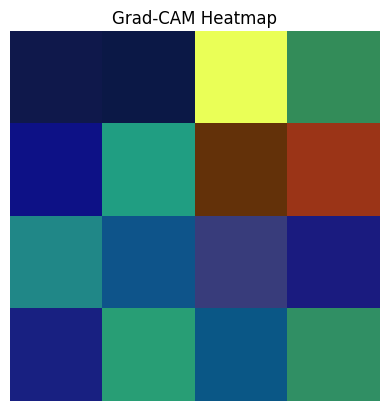

In [12]:
# Use Grad-CAM to visualize the importance
def grad_cam(model, img, metadata, layer_name="out_relu"):
    """
    Compute Grad-CAM heatmap for an image and metadata input.
    Args:
        model: The trained model.
        img: Preprocessed image input (4D tensor with batch dimension).
        metadata: Metadata input (2D tensor with batch dimension).
        layer_name: Target layer for Grad-CAM.
    Returns:
        Heatmap for the specified input.
    """
    grad_model = Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img, metadata])
        loss = predictions[:, 0]  # Assuming binary classification
    
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    heatmap = np.mean(conv_outputs * pooled_grads, axis=-1)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Example usage
sample_img = np.expand_dims(train_images[0], axis=0)  # Add batch dimension
sample_metadata = np.expand_dims(train_metadata_scaled[0], axis=0)  # Add batch dimension
heatmap = grad_cam(shallow_progressive_fusion_model, sample_img, sample_metadata, layer_name="out_relu")

# Visualize the heatmap
plt.imshow(train_images[0])  # Display the original image
plt.imshow(heatmap, cmap="jet", alpha=0.5)  # Overlay the heatmap
plt.title("Grad-CAM Heatmap")
plt.axis("off")
plt.show()



The colormap you see in the Grad-CAM heatmap represents the activation intensity for different parts of the image, showing how much the model focuses on each region when making predictions. 

Here's how to interpret the colors:

Bright Yellow/Green/Red Areas: These indicate regions of high activation where the model is paying the most attention. 

In the context of Grad-CAM:

For classification tasks, these regions are most influential in determining the predicted class.
For other tasks like segmentation, they might correspond to features the model considers critical for its prediction.

Dark Blue Areas: These indicate regions of low activation, meaning the model doesn't find these areas relevant for the prediction.

Bright Yellow/Green/Red Areas (High Activation):

These are the regions of the image that the model finds most influential in deciding the classification.
For example:
If the task involves detecting environmental conditions like "snow" or "leaves on trees," the heatmap should highlight regions corresponding to snow-covered surfaces or tree leaves.
If the task involves identifying other surface features, such as "muddy ground," the heatmap should focus on areas where those features appear in the image.
Dark Blue Areas (Low Activation):

These regions contribute little to the model’s decision.
For instance:
In an image of a snowy field, areas with plain sky or shadows might show up as dark blue, indicating they don't influence the prediction significantly.

In [13]:
# Modify the model to use only image input
def create_image_only_model():
    image_input = Input(shape=(128, 128, 3), name="image_input")
    resnet_base = MobileNetV2(weights="imagenet", include_top=False, input_tensor=image_input)
    x = GlobalAveragePooling2D()(resnet_base.output)
    output = Dense(1, activation="sigmoid", name="output")(x)
    model = Model(inputs=image_input, outputs=output)
    return model

image_only_model = create_image_only_model()
image_only_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
image_only_history = image_only_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=5, batch_size=32
)

# Compare performance with fusion model


/var/folders/b8/l5qsc79j65d03k1x2ybs9ltm0000gn/T/ipykernel_93084/3817162040.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  resnet_base = MobileNetV2(weights="imagenet", include_top=False, input_tensor=image_input)


Epoch 1/5
887/887 ━━━━━━━━━━━━━━━━━━━━ 787s 848ms/step - accuracy: 0.4919 - loss: 0.7347 - val_accuracy: 0.4979 - val_loss: 1.2026
Epoch 2/5
887/887 ━━━━━━━━━━━━━━━━━━━━ 638s 718ms/step - accuracy: 0.5056 - loss: 0.6976 - val_accuracy: 0.4979 - val_loss: 0.6933
Epoch 3/5
887/887 ━━━━━━━━━━━━━━━━━━━━ 614s 692ms/step - accuracy: 0.4970 - loss: 0.6956 - val_accuracy: 0.4984 - val_loss: 0.6932
Epoch 4/5
887/887 ━━━━━━━━━━━━━━━━━━━━ 618s 697ms/step - accuracy: 0.5047 - loss: 0.6954 - val_accuracy: 0.4979 - val_loss: 0.6932
Epoch 5/5
887/887 ━━━━━━━━━━━━━━━━━━━━ 644s 725ms/step - accuracy: 0.5060 - loss: 0.6955 - val_accuracy: 0.4979 - val_loss: 0.6932


# Final Conclusions and Takeaways

### Main Goal: To evaluate whether progressive fusion with SE blocks outperforms early and late fusion methods.

### Outcome: Progressive fusion did not show significant improvement over early and late fusion strategies in accuracy or AUC.

### Possible Reasons:

Dataset size or quality may not have allowed the model to leverage cross-modal interactions effectively.

Model complexity might have introduced overfitting despite using dropout and regularization.

Metadata features may not have been sufficiently informative to boost performance; this in particular, I think, played the biggest role. 

Metadata quality plays a crucial role in multimodal fusion tasks, and if the metadata (or features derived from it) lacks strong correlation with the target variable, the fusion strategies—regardless of their complexity—will struggle to improve performance.

## In multimodal learning:

### Signal Strength: 
Metadata (e.g., brightness, color bands) should add complementary information that images alone cannot provide. If the metadata is noisy or weakly correlated, it becomes more of a distraction than a helpful input.

### Correlation with Labels: 
If metadata isn't strongly correlated with the target surface conditions (e.g., snow, leaves), the fusion mechanism cannot effectively leverage it.

### Feature Redundancy: 
If the digital attributes overlap too much with image features (e.g., brightness is already captured by image intensities), they may not contribute new information.

# Recommendations Moving Forward

1. Improve Metadata Quality
New Features: Explore additional digital attributes that might correlate more strongly with surface conditions, such as:
Textural metrics (e.g., entropy or edge density).
Environmental metadata (e.g., temperature, humidity, elevation).
Satellite-specific indices like NDWI or soil moisture indices.
Domain Expertise: Collaborate with subject-matter experts to identify features more likely to correlate with surface conditions.

2. Feature Engineering
Apply transformations to derive richer metadata features:
Non-linear transformations: Try polynomial features or interaction terms.
Dimensionality Reduction: Use PCA or autoencoders to compress metadata into a more informative latent space.
Custom Metrics: Design custom indices tailored to the specific surface conditions (e.g., snow presence).

3. Analyze the Metadata Alone
Train a simple metadata-only model (e.g., a Random Forest or logistic regression) to evaluate its standalone predictive power. If it performs poorly, the metadata likely lacks predictive utility. --> already did this with my digital attribute classifiers, performed pretty well actually

4. Simpler Fusion Tasks
Test fusion strategies on simpler, synthetic tasks where the correlation between metadata and labels is stronger. This would allow you to isolate and evaluate the effectiveness of the fusion mechanisms themselves.

5. Weighting Metadata Contributions
Use attention mechanisms to dynamically weight the contribution of metadata during fusion. This could help the model "ignore" irrelevant metadata when it's not helpful.

In [19]:
from tensorflow.keras.models import load_model

# Load models
early_fusion_model = load_model("early_fusion_model_final.keras")
late_fusion_model = load_model("late_fusion_model_final.keras")


In [22]:
# Evaluate Early Fusion Model
early_fusion_results = early_fusion_model.evaluate([val_images, val_metadata], val_labels, verbose=1)
print(f"Early Fusion - Test Loss: {early_fusion_results[0]}, Test Accuracy: {early_fusion_results[1]}")

# Evaluate Late Fusion Model
late_fusion_results = late_fusion_model.evaluate([val_images, val_metadata], val_labels, verbose=1)
print(f"Late Fusion - Test Loss: {late_fusion_results[0]}, Test Accuracy: {late_fusion_results[1]}")


/Users/lisaliubovich/myenv2/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'metadata_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.4999 - loss: 0.6932
Early Fusion - Test Loss: 0.6931660771369934, Test Accuracy: 0.5025366544723511
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.4956 - loss: 0.6932
Late Fusion - Test Loss: 0.6932259798049927, Test Accuracy: 0.492671936750412


In [4]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the saved models
tuned_model = load_model("progressive_fusion_model_final.keras")
shallow_model = load_model("shallow_progressive_fusion_model_final.keras")

# Evaluate the tuned model
tuned_train_results = tuned_model.evaluate([train_images, train_metadata], train_labels, verbose=2)
tuned_val_results = tuned_model.evaluate([val_images, val_metadata], val_labels, verbose=2)

# Evaluate the shallower model
shallow_train_results = shallow_model.evaluate([train_images, train_metadata], train_labels, verbose=2)
shallow_val_results = shallow_model.evaluate([val_images, val_metadata], val_labels, verbose=2)

# Extract metrics
metrics_names = tuned_model.metrics_names

# Display results
print("Metrics:", metrics_names)
print("\nProgressive Fusion (Tuned) Model:")
print(f"Train - Loss: {tuned_train_results[0]:.4f}, Accuracy: {tuned_train_results[1]:.4f}, AUC: {tuned_train_results[2]:.4f}")
print(f"Validation - Loss: {tuned_val_results[0]:.4f}, Accuracy: {tuned_val_results[1]:.4f}, AUC: {tuned_val_results[2]:.4f}")

print("\nShallower Progressive Fusion Model:")
print(f"Train - Loss: {shallow_train_results[0]:.4f}, Accuracy: {shallow_train_results[1]:.4f}, AUC: {shallow_train_results[2]:.4f}")
print(f"Validation - Loss: {shallow_val_results[0]:.4f}, Accuracy: {shallow_val_results[1]:.4f}, AUC: {shallow_val_results[2]:.4f}")


2024-12-03 17:32:28.266642: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-12-03 17:32:28.266680: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-03 17:32:28.266688: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-03 17:32:28.266713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 17:32:28.266731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/lisaliubovich/myenv2/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_inp

887/887 - 41s - 46ms/step - accuracy: 0.5973 - auc: 0.6049 - loss: 11.5014
222/222 - 10s - 44ms/step - accuracy: 0.4992 - auc: 0.5049 - loss: 3.2244
887/887 - 29s - 33ms/step - accuracy: 0.5113 - auc: 0.5226 - loss: 0.7252
222/222 - 7s - 32ms/step - accuracy: 0.5028 - auc: 0.5112 - loss: 0.7340
Metrics: ['loss', 'compile_metrics']

Progressive Fusion (Tuned) Model:
Train - Loss: 11.5014, Accuracy: 0.5973, AUC: 0.6049
Validation - Loss: 3.2244, Accuracy: 0.4992, AUC: 0.5049

Shallower Progressive Fusion Model:
Train - Loss: 0.7252, Accuracy: 0.5113, AUC: 0.5226
Validation - Loss: 0.7340, Accuracy: 0.5028, AUC: 0.5112


In [5]:
# Check the training data size
train_data_size = train_images.shape[0]
train_metadata_size = train_metadata.shape[0]
train_labels_size = train_labels.shape[0]

# Check the validation data size
val_data_size = val_images.shape[0]
val_metadata_size = val_metadata.shape[0]
val_labels_size = val_labels.shape[0]

# Display the data split
print("Training Data Split:")
print(f"Number of Training Images: {train_data_size}")
print(f"Number of Training Metadata: {train_metadata_size}")
print(f"Number of Training Labels: {train_labels_size}")

print("\nValidation Data Split:")
print(f"Number of Validation Images: {val_data_size}")
print(f"Number of Validation Metadata: {val_metadata_size}")
print(f"Number of Validation Labels: {val_labels_size}")


Training Data Split:
Number of Training Images: 28383
Number of Training Metadata: 28383
Number of Training Labels: 28383

Validation Data Split:
Number of Validation Images: 7096
Number of Validation Metadata: 7096
Number of Validation Labels: 7096


NameError: name 'results' is not defined

<Figure size 1000x600 with 0 Axes>